In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
            #nn.LayerNorm(latent_dim)  # helps stabilize training
        )

    def forward(self, x):
        # x: (batch, time, features)
        B, T, F = x.shape
        x = x.view(B * T, F)
        z = self.encoder(x)
        z = z.view(B, T, -1)
        return z  # (batch, time, latent_dim)

class AutoregressiveModel(nn.Module):
    def __init__(self, latent_dim, context_dim):
        super().__init__()
        self.lstm = nn.LSTM(latent_dim, context_dim, batch_first=True)

    def forward(self, z):
        c, _ = self.lstm(z)  # (batch, time, context_dim)
        return c

class CPC(nn.Module):
    def __init__(self, input_dim, latent_dim=20, context_dim=128, predict_k=5):
        super().__init__()
        self.g_enc = Encoder(input_dim, latent_dim)
        self.g_ar = AutoregressiveModel(latent_dim, context_dim)
        self.Wk = nn.ModuleList([
            nn.Linear(context_dim, latent_dim) for _ in range(predict_k)
        ])
        self.predict_k = predict_k

    def forward(self, x):
        z = self.g_enc(x)  # (B, T, D)
        c = self.g_ar(z)   # (B, T, H)

        return z, c

    def compute_loss(self, z, c):
        B, T, D = z.shape
        total_loss = 0.0
        valid_k = 0
    
        for k in range(1, self.predict_k + 1):
            if T - k <= 0:
                continue  # skip if sequence too short
    
            z_pos = z[:, k:, :]          # (B, T−k, D)
            c_t = c[:, :-k, :]           # (B, T−k, H)
            preds = self.Wk[k - 1](c_t)  # (B, T−k, D)
    
            # Compute dot products: (B, T−k, T−k)
            logits = torch.matmul(preds, z_pos.transpose(1, 2))
    
            # Flatten to (B * (T−k), T−k)
            B_, T_, _ = logits.shape
            logits = logits.reshape(B_ * T_, T_)
    
            # Labels: always diagonal → [0, 1, ..., T−k-1] repeated B times
            labels = torch.arange(T_, device=z.device).repeat(B_)
    
            loss = F.cross_entropy(logits, labels)
            total_loss += loss
            valid_k += 1
    
        return total_loss / valid_k if valid_k > 0 else torch.tensor(0.0, device=z.device)


In [3]:
def train_cpc(model, dataloader, optimizer, device, epochs=20):
    model.to(device)
    model.train()

    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in loop:
            
            x = batch[0].to(device)  # Shape: (B, T, F)

            z, c = model(x)  # Forward pass: latent + context
            loss = model.compute_loss(z, c)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            loop.set_postfix(loss=loss.item())

        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1} avg loss: {avg_loss:.4f}")
        
        losses.append(avg_loss)
        
    return losses


In [4]:
# Initialize dataset and dataloader
# === PART 1 OF Q3.1 ===

# Load preprocessed datasets
df_a = pd.read_parquet('ml_ready_data/set-a-scaled.parquet')  # Train set
df_b = pd.read_parquet('ml_ready_data/set-b-scaled.parquet')
df_c = pd.read_parquet('ml_ready_data/set-c-scaled.parquet')  # Test set

static_vars = ['Age', 'Gender', 'Height', 'Weight']

# Extract time_series_vars separately for each dataset
time_series_vars_a = [col for col in df_a.columns if col not in static_vars + ['Hour', 'PatientID', 'RecordID', 'In_hospital_death']]
time_series_vars_b = [col for col in df_b.columns if col not in static_vars + ['Hour', 'PatientID', 'RecordID', 'In_hospital_death']]
time_series_vars_c = [col for col in df_c.columns if col not in static_vars + ['Hour', 'PatientID', 'RecordID', 'In_hospital_death']]

# Extract full data for each dataset using its own time series variables
full_data_a = df_a[static_vars + time_series_vars_a]
full_data_b = df_b[static_vars + time_series_vars_b]
full_data_c = df_c[static_vars + time_series_vars_c]

# Print shapes to verify
print("full_data_a shape:", full_data_a.shape)
print("full_data_b shape:", full_data_b.shape)
print("full_data_c shape:", full_data_c.shape)


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your NumPy data
data_train = np.load("data_train.npy")  # shape: (N, T, F)

# Convert to PyTorch Tensor
data_train_tensor = torch.from_numpy(data_train).float()

# Wrap in TensorDataset
dataset = TensorDataset(data_train_tensor)


full_data_a shape: (196000, 41)
full_data_b shape: (196000, 41)
full_data_c shape: (196000, 41)


# extract data_train.npy

In [5]:
patient_sequences = []
patient_ids = df_a['PatientID'].unique()

for pid in patient_ids:
    # Filter data for this patient
    patient_data = df_a[df_a['PatientID'] == pid]
    
    # Drop PatientID column, keep only features
    patient_features = patient_data[static_vars + time_series_vars_a].to_numpy()
    
    # Optional sanity check: you expect 49 timesteps
    if patient_features.shape[0] != 49:
        print(f"Patient {pid} has {patient_features.shape[0]} timesteps!")
    
    patient_sequences.append(patient_features)

# Step 3: Convert to a NumPy array
data_array = np.stack(patient_sequences)  # shape: (num_patients, 49, 41)

# Optional: confirm shape
print("Data shape:", data_array.shape)  # should be (4000, 49, 41)

Data shape: (4000, 49, 41)


In [6]:
np.save("data_train.npy", data_array)

# extract data_test_c.npy

In [7]:
patient_sequences = []
patient_ids = df_c['PatientID'].unique()

for pid in patient_ids:
    # Filter data for this patient
    patient_data = df_c[df_c['PatientID'] == pid]
    
    # Drop PatientID column, keep only features
    patient_features = patient_data[static_vars + time_series_vars_a].to_numpy()
    
    # Optional sanity check: you expect 49 timesteps
    if patient_features.shape[0] != 49:
        print(f"Patient {pid} has {patient_features.shape[0]} timesteps!")
    
    patient_sequences.append(patient_features)

# Step 3: Convert to a NumPy array
data_array = np.stack(patient_sequences)  # shape: (num_patients, 49, 41)

# Optional: confirm shape
print("Data shape:", data_array.shape)  # should be (4000, 49, 41)

Data shape: (4000, 49, 41)


In [8]:
np.save("data_test_c.npy", data_array)

# load dataset_test_c

In [9]:
data_test_c = np.load("data_test_c.npy")
data_test_c_tensor = torch.from_numpy(data_test_c).float()
dataset_test_c = TensorDataset(data_test_c_tensor)

In [12]:
# hyperparameters
epochs = 20
batch_size = 32
lr = 2e-4
input_dim = 41
latent_dim = 16
context_dim = 512
predict_k = 10

In [14]:
# Create dataloader for training
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_test_c = DataLoader(dataset_test_c, batch_size=batch_size, shuffle=True)
#Initialize Model
model = CPC(input_dim=input_dim, latent_dim = latent_dim, context_dim=context_dim, predict_k=predict_k)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [15]:
losses = train_cpc(model, dataloader, optimizer, device, epochs)

Epoch 1/20: 100%|██████████| 125/125 [00:04<00:00, 29.26it/s, loss=6.79]


Epoch 1 avg loss: 4.2633


Epoch 2/20: 100%|██████████| 125/125 [00:04<00:00, 30.43it/s, loss=3.88]


Epoch 2 avg loss: 4.0534


Epoch 3/20: 100%|██████████| 125/125 [00:04<00:00, 29.95it/s, loss=4.34]


Epoch 3 avg loss: 3.9539


Epoch 4/20: 100%|██████████| 125/125 [00:04<00:00, 29.62it/s, loss=4.7] 


Epoch 4 avg loss: 3.9371


Epoch 5/20: 100%|██████████| 125/125 [00:03<00:00, 39.20it/s, loss=3.93]


Epoch 5 avg loss: 3.8972


Epoch 6/20: 100%|██████████| 125/125 [00:04<00:00, 29.69it/s, loss=3.72]


Epoch 6 avg loss: 3.9173


Epoch 7/20: 100%|██████████| 125/125 [00:04<00:00, 29.72it/s, loss=3.78]


Epoch 7 avg loss: 3.8628


Epoch 8/20: 100%|██████████| 125/125 [00:04<00:00, 29.70it/s, loss=4.08]


Epoch 8 avg loss: 3.8899


Epoch 9/20: 100%|██████████| 125/125 [00:04<00:00, 30.56it/s, loss=3.75]


Epoch 9 avg loss: 3.8415


Epoch 10/20: 100%|██████████| 125/125 [00:03<00:00, 31.46it/s, loss=3.72]


Epoch 10 avg loss: 3.8597


Epoch 11/20: 100%|██████████| 125/125 [00:03<00:00, 32.85it/s, loss=3.79]


Epoch 11 avg loss: 3.8176


Epoch 12/20: 100%|██████████| 125/125 [00:04<00:00, 30.46it/s, loss=3.84]


Epoch 12 avg loss: 3.8028


Epoch 13/20: 100%|██████████| 125/125 [00:04<00:00, 28.93it/s, loss=4.19]


Epoch 13 avg loss: 3.7895


Epoch 14/20: 100%|██████████| 125/125 [00:04<00:00, 29.17it/s, loss=3.73]


Epoch 14 avg loss: 3.7761


Epoch 15/20: 100%|██████████| 125/125 [00:04<00:00, 30.24it/s, loss=3.7] 


Epoch 15 avg loss: 3.7566


Epoch 16/20: 100%|██████████| 125/125 [00:04<00:00, 29.52it/s, loss=3.69]


Epoch 16 avg loss: 3.7541


Epoch 17/20: 100%|██████████| 125/125 [00:03<00:00, 36.50it/s, loss=3.71]


Epoch 17 avg loss: 3.7475


Epoch 18/20: 100%|██████████| 125/125 [00:03<00:00, 33.77it/s, loss=3.83]


Epoch 18 avg loss: 3.7483


Epoch 19/20: 100%|██████████| 125/125 [00:03<00:00, 32.50it/s, loss=3.68]


Epoch 19 avg loss: 3.7218


Epoch 20/20: 100%|██████████| 125/125 [00:04<00:00, 30.24it/s, loss=3.6] 

Epoch 20 avg loss: 3.6840


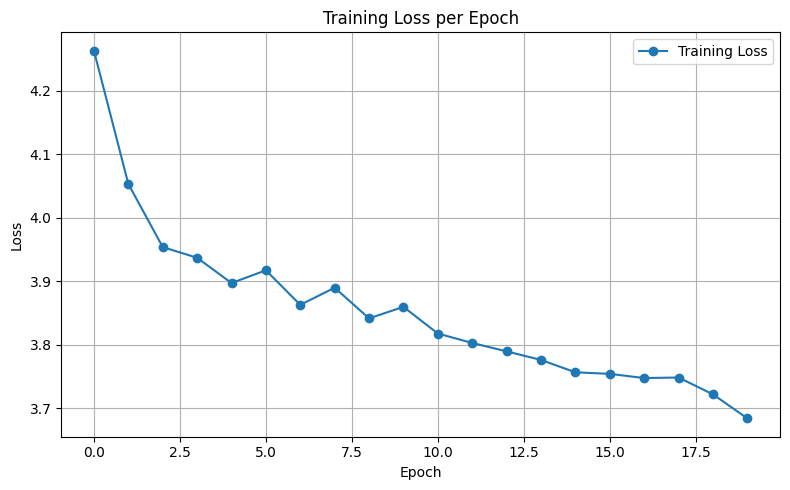

In [16]:

plt.figure(figsize=(8, 5))
plt.plot(losses, marker='o', label='Training Loss')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Freeze model
for param in model.parameters():
    param.requires_grad = False

In [18]:
import torch
from tqdm import tqdm

def extract_patient_embeddings(model, dataloader, device, save_path="patient_embeddings.pt"):
    """
    Extracts a 128-dimensional embedding per patient from a trained and frozen CPC model.

    Args:
        model (nn.Module): Trained CPC model.
        dataloader (DataLoader): DataLoader yielding (B, T, F) input batches.
        device (torch.device): e.g., torch.device('cuda') or torch.device('cpu').
        save_path (str): File path to save the embeddings.

    Returns:
        torch.Tensor: Tensor of shape (num_patients, 128).
    """

    model.eval()
    model.to(device)

    all_embeddings = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting embeddings"):
            x = batch[0].to(device)  # assuming batch = (data, labels), shape: (B, T, F)

            # Encode + context modeling
            z = model.g_enc(x)         # (B, T, latent_dim)
            c = model.g_ar(z)          # (B, T, 128)

            # Mean-pooling over time
            patient_embeddings = c.mean(dim=1)  # (B, 128)

            all_embeddings.append(patient_embeddings.cpu())

    all_embeddings = torch.cat(all_embeddings, dim=0)  # (N, 128), where N = total patients
    torch.save(all_embeddings, save_path)

    print(f"Saved embeddings to {save_path}")
    return all_embeddings


# extract train and test embeddings

In [19]:
embeddings_train = extract_patient_embeddings(model, dataloader, device)
embeddings_test_c = extract_patient_embeddings(model, dataloader_test_c, device)
print(embeddings_train.shape)  # should print: torch.Size([4000, 128])
print(embeddings_test_c.shape)  # should print: torch.Size([4000, 128])

Extracting embeddings: 100%|██████████| 125/125 [00:00<00:00, 309.96it/s]


Saved embeddings to patient_embeddings.pt


Extracting embeddings: 100%|██████████| 125/125 [00:00<00:00, 363.92it/s]

Saved embeddings to patient_embeddings.pt
torch.Size([4000, 512])
torch.Size([4000, 512])


# visualize trianing embeddings

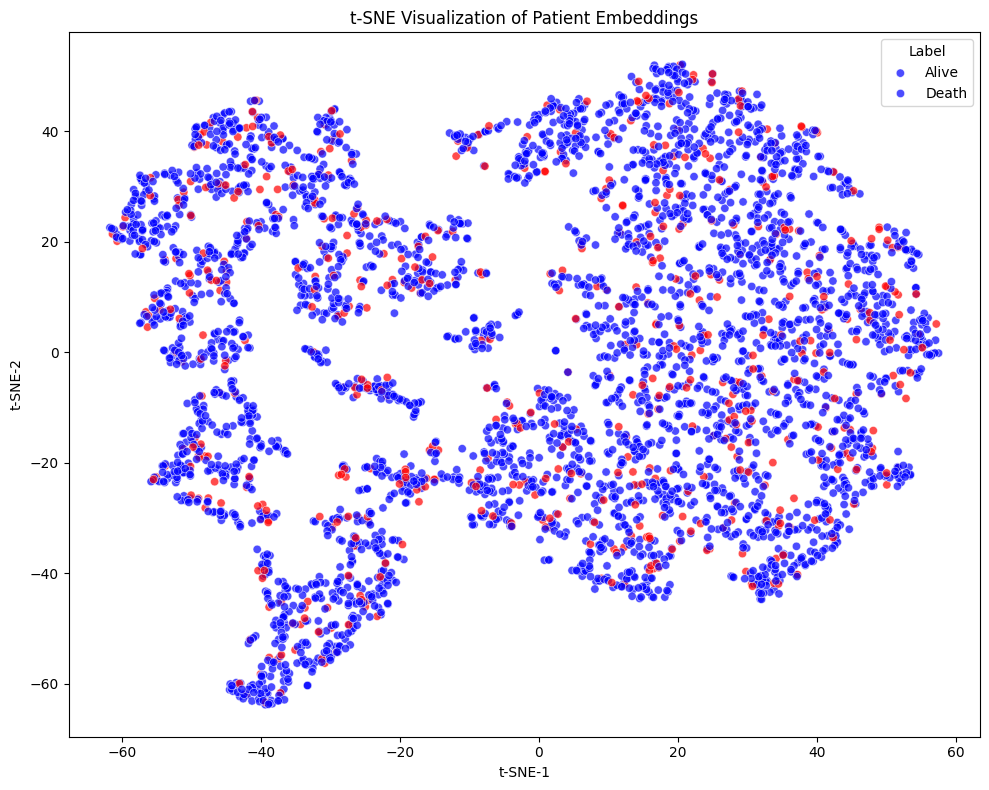

In [20]:
import torch
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load embeddings
#embeddings = torch.load("patient_embeddings.pt")  # shape: (4000, 128)
embeddings_train_np = embeddings_train.numpy()

# Map patient labels (e.g., from PatientID to alive/death)
# Ensure unique label per patient
y_labels = df_a.groupby('PatientID')['In_hospital_death'].last().values

# Convert labels to numeric
label_mapping = {"alive": 0, "death": 1}

# 3. Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings_train_np)  # shape: (4000, 2)

# 4. Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=tsne_result[:, 0], y=tsne_result[:, 1],
    hue=y_labels,
    palette={0: "blue", 1: "red"},
    legend="full",
    alpha=0.7
)
plt.title("t-SNE Visualization of Patient Embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend(title="Label", labels=["Alive", "Death"])
plt.tight_layout()
plt.show()

# Training set performance.. 

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from tqdm import tqdm

# 1. Load embeddings and labels
#embeddings = torch.load("patient_embeddings.pt")  # shape: (4000, 128)

y_labels = df_a.groupby('PatientID')['In_hospital_death'].last().values  # shape: (4000,)
y_labels = torch.tensor(y_labels).float()  # For BCE loss

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_train, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# 3. DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 4. Define logistic regression model
class FancyLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.features = nn.Sequential(
            #nn.BatchNorm1d(input_dim),           # normalize input features
            #nn.Dropout(0.2),                     # dropout for regularization
            nn.Linear(input_dim, 32),     # feature transformation (still linear)
            nn.ReLU(),                           # non-linearity (optional but lightweight)
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.classifier = nn.Linear(16, 1)  # final logistic regression layer

    def forward(self, x):
        x = self.features(x)
        return torch.sigmoid(self.classifier(x))

model = FancyLogisticRegression(input_dim=context_dim)  # For example 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 5. Train
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

for epoch in range(10):
    model.train()
    total_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        preds = model(x_batch).squeeze(1)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# 6. Evaluate
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        preds = model(x_batch).squeeze(1).cpu()
        all_preds.append(preds)
        all_labels.append(y_batch)

all_preds = torch.cat(all_preds)         # Predicted probabilities
all_labels = torch.cat(all_labels)       # Ground truth (0 or 1)
pred_labels = (all_preds > 0.5).float()  # Binary predictions

# 7. Metrics
acc = accuracy_score(all_labels, pred_labels)
auroc = roc_auc_score(all_labels, all_preds)
auprc = average_precision_score(all_labels, all_preds)

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test AUROC:    {auroc:.4f}")
print(f"Test AUPRC:    {auprc:.4f}")


Epoch 1, Loss: 0.4726
Epoch 2, Loss: 0.4113
Epoch 3, Loss: 0.4065
Epoch 4, Loss: 0.4064
Epoch 5, Loss: 0.4114
Epoch 6, Loss: 0.4076
Epoch 7, Loss: 0.4076
Epoch 8, Loss: 0.4068
Epoch 9, Loss: 0.4075
Epoch 10, Loss: 0.4049

Test Accuracy: 0.8612
Test AUROC:    0.4607
Test AUPRC:    0.1390


# Test set performance..

In [25]:


# 1. Load embeddings and new labels from df_c
y_labels_c = df_c.groupby('PatientID')['In_hospital_death'].last().values  # Shape: (num_patients_in_c,)
y_labels_c = torch.tensor(y_labels_c).float()  # For BCE loss

# 2. DataLoader for the new test set
test_dataset_c = TensorDataset(embeddings_test_c, y_labels_c)
test_loader_c = DataLoader(test_dataset_c, batch_size=32)

# 3. Define the FancyLogisticRegression model again if not loaded
# Assuming 'FancyLogisticRegression' class is already defined

model = FancyLogisticRegression(input_dim=context_dim)  # Input_dim should be 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. Freeze the model (stop the model from updating its weights)
for param in model.parameters():
    param.requires_grad = False

# 5. Load the trained weights (if necessary, e.g., from a checkpoint file)
# model.load_state_dict(torch.load("model_weights.pth"))  # Uncomment if you saved the model weights

# 6. Evaluate the frozen model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_loader_c:
        x_batch = x_batch.to(device)
        preds = model(x_batch).squeeze(1).cpu()  # Make sure the prediction is squeezed to shape (batch_size,)
        all_preds.append(preds)
        all_labels.append(y_batch)

# Concatenate all the predictions and labels
all_preds = torch.cat(all_preds)         # Predicted probabilities
all_labels = torch.cat(all_labels)       # Ground truth (0 or 1)

# Binary predictions (0 or 1)
pred_labels = (all_preds > 0.5).float()

# 7. Metrics
acc = accuracy_score(all_labels, pred_labels)
auroc = roc_auc_score(all_labels, all_preds)
auprc = average_precision_score(all_labels, all_preds)

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test AUROC:    {auroc:.4f}")
print(f"Test AUPRC:    {auprc:.4f}")



Test Accuracy: 0.8538
Test AUROC:    0.4977
Test AUPRC:    0.1514


# 3.2 Supervised CPC model

In [27]:
class SupervisedCPC(nn.Module):
    def __init__(self, input_dim, latent_dim=20, context_dim=128):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.context = AutoregressiveModel(latent_dim, context_dim)
        self.classifier = nn.Sequential(
            nn.Linear(context_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: (batch, time, input_dim)
        z = self.encoder(x)             # (B, T, latent_dim)
        c = self.context(z)             # (B, T, context_dim)
        c_final = c[:, -1, :]           # Use final time step's context vector (B, context_dim)
        out = self.classifier(c_final)  # (B, 1)
        return torch.sigmoid(out).squeeze(1)

In [35]:
def check_balance(df, sample_size=1000, seed=42):
    sample = df.sample(n=sample_size, random_state=seed)
    counts = sample["In_hospital_death"].value_counts()
    total = counts.sum()
    for label, count in counts.items():
        print(f"Label {label}: {count} ({count / total:.2%})")

# Examples
check_balance(df_a, sample_size=100)
check_balance(df_a, sample_size=500)
check_balance(df_a, sample_size=1000)


Label 0: 86 (86.00%)
Label 1: 14 (14.00%)
Label 0: 431 (86.20%)
Label 1: 69 (13.80%)
Label 0: 868 (86.80%)
Label 1: 132 (13.20%)


# get balanced subsets of training data :)

In [38]:
def get_balanced_subset(df, total_samples=100, seed=42):
    n_per_class = total_samples // 2  # Half for each class

    # Make sure there are enough samples in each class
    assert df["In_hospital_death"].value_counts().min() >= n_per_class, "Not enough samples in one of the classes."

    dead_samples = df[df["In_hospital_death"] == 1].sample(n=n_per_class, random_state=seed)
    alive_samples = df[df["In_hospital_death"] == 0].sample(n=n_per_class, random_state=seed)

    balanced_df = pd.concat([dead_samples, alive_samples]).sample(frac=1, random_state=seed)  # shuffle
    return balanced_df

# Balanced subsets
df_bal_100 = get_balanced_subset(df_a, total_samples=100)
df_bal_500 = get_balanced_subset(df_a, total_samples=500)
df_bal_1000 = get_balanced_subset(df_a, total_samples=1000)

# Check balance
check_balance(df_bal_100, sample_size=100)
check_balance(df_bal_500, sample_size=500)
check_balance(df_bal_1000, sample_size=1000)

Label 1: 50 (50.00%)
Label 0: 50 (50.00%)
Label 0: 250 (50.00%)
Label 1: 250 (50.00%)
Label 0: 500 (50.00%)
Label 1: 500 (50.00%)


In [58]:
print(df_bal_100.shape)
print(df_bal_100["PatientID"])  # list pateint ID's
ids_100 = df_bal_100[["PatientID"]]



(100, 45)
141569    133463
93240     137285
121933    140462
96154     134823
166346    138391
           ...  
137371    141157
105555    136840
91685     135453
121067    134161
177914    139009
Name: PatientID, Length: 100, dtype: object


In [42]:
df_bal_100_train = df_bal_100[static_vars + time_series_vars_a]
print(df_bal_100_train.shape)

df_bal_500_train = df_bal_500[static_vars + time_series_vars_a]
print(df_bal_100_train.shape)

df_bal_1000_train = df_bal_1000[static_vars + time_series_vars_a]
print(df_bal_100_train.shape)

(100, 41)
(100, 41)
(100, 41)
